# Chapter 7. 텍스트 문서의 범주화 - (6) CNN 모델을 이용한 다중 클래스 분류

- 이제 다중 클래스 분류에 동일한 모델을 적용해 보자.
- 이를 위해 20 NewsGroup 데이터 세트를 사용한다.
    - 20 NewsGroup 데이터는 함수 sklearn 함수 호출로 가져오므로 별도로 다운받을 필요 없음
- 모델은 학습된 GloVe 모델로 임베딩 초기화만 적용한다
    

In [1]:
import os
import config
from dataloader.loader import Loader
from preprocessing.utils import Preprocess, remove_empty_docs
from dataloader.embeddings import GloVe
from model.cnn_document_model import DocumentModel, TrainingParameters
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from keras.utils import to_categorical
import keras.backend as K
from sklearn.manifold import TSNE
from utils import scatter_plot
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

Using TensorFlow backend.


## 20 News Group 데이터셋 로드

- 20 News Group 데이터셋은 sklearn의 패치함수를 통해 자동으로 다운로드 받는다

In [2]:
dataset = Loader.load_20newsgroup_data(subset='train')
corpus, labels = dataset.data, dataset.target
corpus, labels = remove_empty_docs(corpus, labels)

test_dataset = Loader.load_20newsgroup_data(subset='test')
test_corpus, test_labels = test_dataset.data, test_dataset.target
test_corpus, test_labels = remove_empty_docs(test_corpus, test_labels)

In [3]:
print(f'corpus size : {len(corpus)}')
print(f'labels size : {len(labels)}')
print(f'test_corpus size : {len(test_corpus)}')
print(f'test_labels size : {len(test_labels)}')

corpus size : 11014
labels size : 11014
test_corpus size : 7318
test_labels size : 7318


## 20개 그룹을 6개 상위그룹으로 매핑

In [4]:
six_groups = {
    'comp.graphics':0,'comp.os.ms-windows.misc':0,'comp.sys.ibm.pc.hardware':0,
    'comp.sys.mac.hardware':0, 'comp.windows.x':0,
    
    'rec.autos':1, 'rec.motorcycles':1, 'rec.sport.baseball':1, 'rec.sport.hockey':1,
    
    'sci.crypt':2, 'sci.electronics':2,'sci.med':2, 'sci.space':2,
    
    'misc.forsale':3,
    
    'talk.politics.misc':4, 'talk.politics.guns':4, 'talk.politics.mideast':4,
    
    'talk.religion.misc':5, 'alt.atheism':5, 'soc.religion.christian':5
    
}

In [5]:
map_20_2_6 = [six_groups[dataset.target_names[i]] for i in range(20)]
labels = [six_groups[dataset.target_names[i]] for i in labels] 
test_labels = [six_groups[dataset.target_names[i]] for i in test_labels]

In [6]:
map_20_2_6

[5, 0, 0, 0, 0, 0, 3, 1, 1, 1, 1, 2, 2, 2, 2, 5, 4, 4, 4, 5]

## 데이터셋을 인덱스 시퀀스로 변환

In [7]:
Preprocess.MIN_WD_COUNT=5
preprocessor = Preprocess(corpus=corpus)
corpus_to_seq = preprocessor.fit()

Found 19538 unique tokens.
All documents processed.cessed.

In [8]:
test_corpus_to_seq = preprocessor.transform(test_corpus)

All documents processed.cessed.

## 임베딩 초기화

data 디렉토리에 저장한 GloVe 모델을 로드하여 초기화된 임베딩 매트릭스 생성

In [9]:
glove=GloVe(50)
initial_embeddings = glove.get_embedding(preprocessor.word_index)

Reading 50 dim GloVe vectors
Found 400000 word vectors.
words not found in embeddings: 1268


## 모델 빌드하기

In [10]:
newsgrp_model = DocumentModel(vocab_size=preprocessor.get_vocab_size(),
                                    sent_k_maxpool = 5,
                                    sent_filters = 20,
                                    word_kernel_size = 5,
                                    word_index = preprocessor.word_index,
                                    num_sentences=Preprocess.NUM_SENTENCES,                                    
                                    embedding_weights=initial_embeddings,
                                    conv_activation = 'relu',
                                    train_embedding = True,
                                    learn_word_conv = True,
                                    learn_sent_conv = True,
                                    sent_dropout = 0.4,
                                    hidden_dims=64,                                        
                                    input_dropout=0.2, 
                                    hidden_gaussian_noise_sd=0.5,
                                    final_layer_kernel_regularizer=0.1,
                                    num_hidden_layers=2,
                                    num_units_final_layer=6)

Vocab Size = 19540  and the index of vocabulary words passed has 19538 words
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## 파라미터 저장

In [11]:
if not os.path.exists(os.path.join(config.MODEL_DIR, '20newsgroup')):
    os.makedirs(os.path.join(config.MODEL_DIR, '20newsgroup'))

train_params = TrainingParameters('6_newsgrp_largeclass', 
                                  model_file_path = config.MODEL_DIR+ '/20newsgroup/model_6_01.hdf5',
                                  model_hyper_parameters = config.MODEL_DIR+ '/20newsgroup/model_6_01.json',
                                  model_train_parameters = config.MODEL_DIR+ '/20newsgroup/model_6_01_meta.json',
                                  num_epochs=20,
                                  batch_size = 128,
                                  validation_split=.10,
                                  learning_rate=0.01)

train_params.save()
newsgrp_model._save_model(train_params.model_hyper_parameters)

## 모델 학습

In [12]:
# 모델 컴파일
newsgrp_model._model.compile(loss="categorical_crossentropy", 
                            optimizer=train_params.optimizer,
                            metrics=["accuracy"])

# 콜백 함수
checkpointer = ModelCheckpoint(filepath=train_params.model_file_path,
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=True)

# 콜백 함수
early_stop = EarlyStopping(patience=2)

In [13]:
x_train = np.array(corpus_to_seq)
y_train  = to_categorical(np.array(labels))
x_test = np.array(test_corpus_to_seq)
y_test = to_categorical(np.array(test_labels))

print(f'x_train.shape : {x_train.shape}')
print(f'y_train.shape : {y_train.shape}')
print(f'x_test.shape : {x_test.shape}')
print(f'y_test.shape : {y_test.shape}')

x_train.shape : (11014, 300)
y_train.shape : (11014, 6)
x_test.shape : (7318, 300)
y_test.shape : (7318, 6)


In [14]:
# learning rate 설정
K.set_value(newsgrp_model.get_classification_model().optimizer.lr, train_params.learning_rate)

# 학습 시작
newsgrp_model.get_classification_model().fit(x_train, y_train, 
                      batch_size=train_params.batch_size, 
                      epochs=train_params.num_epochs,
                      verbose=2,
                      validation_split=train_params.validation_split,
                      callbacks=[checkpointer,early_stop])


Instructions for updating:
Use tf.cast instead.
Train on 9912 samples, validate on 1102 samples
Epoch 1/20
 - 9s - loss: 1.6320 - acc: 0.4088 - val_loss: 1.1913 - val_acc: 0.5517

Epoch 00001: val_loss improved from inf to 1.19125, saving model to ./checkpoint/20newsgroup/model_6_01.hdf5
Epoch 2/20
 - 8s - loss: 1.0330 - acc: 0.6074 - val_loss: 0.9890 - val_acc: 0.6343

Epoch 00002: val_loss improved from 1.19125 to 0.98896, saving model to ./checkpoint/20newsgroup/model_6_01.hdf5
Epoch 3/20
 - 8s - loss: 0.7519 - acc: 0.7487 - val_loss: 1.2668 - val_acc: 0.6107

Epoch 00003: val_loss did not improve from 0.98896
Epoch 4/20
 - 8s - loss: 0.6220 - acc: 0.7999 - val_loss: 0.8812 - val_acc: 0.7069

Epoch 00004: val_loss improved from 0.98896 to 0.88118, saving model to ./checkpoint/20newsgroup/model_6_01.hdf5
Epoch 5/20
 - 8s - loss: 0.5068 - acc: 0.8324 - val_loss: 0.6050 - val_acc: 0.8022

Epoch 00005: val_loss improved from 0.88118 to 0.60499, saving model to ./checkpoint/20newsgroup/m

In [15]:
# 모델 평가
newsgrp_model.get_classification_model().evaluate( x_test, y_test,  verbose=2)

[0.8814248320638693, 0.7838207160589244]

In [16]:
# 테스트셋에 대한 예측 결과
preds = newsgrp_model.get_classification_model().predict(x_test)
preds_test = np.argmax(preds, axis=1)

## 모델 평가

In [17]:
print(classification_report(test_labels, preds_test))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85      1912
           1       0.85      0.86      0.86      1534
           2       0.79      0.70      0.74      1523
           3       0.84      0.41      0.55       382
           4       0.84      0.61      0.71      1027
           5       0.64      0.88      0.74       940

   micro avg       0.78      0.78      0.78      7318
   macro avg       0.79      0.73      0.74      7318
weighted avg       0.79      0.78      0.78      7318



In [18]:
# confusion matrix는 가로가 actual class, 세로가 prediced class임
print(confusion_matrix(test_labels, preds_test))

[[1742   36   96    8    3   27]
 [  45 1322   69   15   36   47]
 [ 232   82 1063    4   43   99]
 [ 160   47   11  155    4    5]
 [  11   39   68    1  623  285]
 [  15   21   41    1   31  831]]


In [19]:
print(accuracy_score(test_labels, preds_test))

0.7838207160426346


## 문서 임베딩 시각화
앞에서 소개한 문서 CNN 모델에는 문서 임베딩층이 있다. 이 층에서 모델이 배운 특성을 시각화해 보자.

In [20]:
doc_embeddings = newsgrp_model.get_document_model().predict(x_test)
print(doc_embeddings.shape)

(7318, 80)


In [21]:
doc_proj = TSNE(n_components=2, random_state=42, ).fit_transform(doc_embeddings)

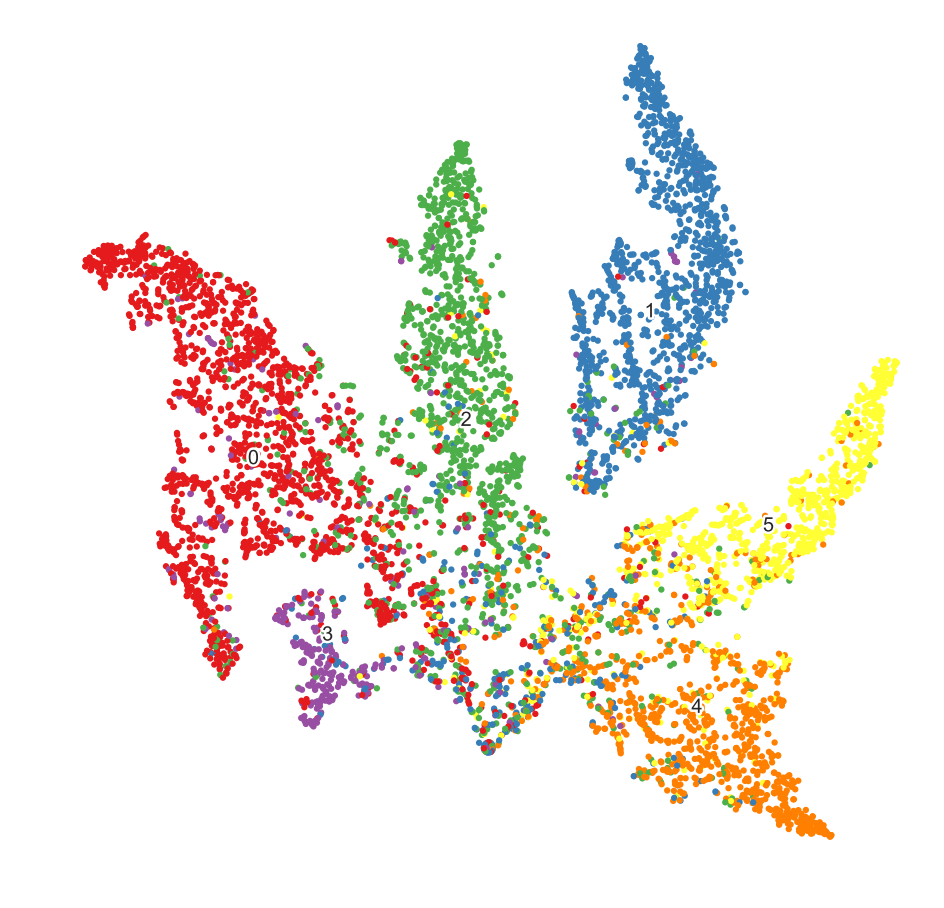

In [22]:
f, ax, sc, txts, plt = scatter_plot(doc_proj, np.array(test_labels))

In [23]:
f.savefig('assets/handson06_nws_grp_embd.png')

- 흩어져 있는 레이블 (0-5)는 여섯 개의 클래스를 나타낸다
- 모델은 적절한 임베딩을 학습했고 80차원 공간에서 6개의 클래스를 잘 구분했다